<a href="https://colab.research.google.com/github/Ale9806/Identificaci-n_facial_mediante_una_red_neuronal_convolucional_siamesa./blob/main/TrainSiameseNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,BatchNormalization, Lambda,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
tf.__version__


from google.colab import drive
drive.mount('/content/drive')

import os 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()
os.chdir("/content")
os.listdir()

['.config', 'model.png', 'drive', 'sample_data']

### Load Data

In [ ]:
image_generator  =
PATH = "/content/drive/MyDrive/Faces"
dataset    = image_generator.flow_from_directory(directory=PATH,shuffle=True,target_size=(224, 224),class_mode='categorical')

Found 16 images belonging to 3 classes.


## CreatePairs

In [ ]:
def createpairs(dataset,verbose: bool = True):
    images = dataset[0][0]
    labels = dataset[0][1]
    Total  = len(labels)
    LABELS = []
    IMAGES1 = []
    IMAGES2 = []
    for i in range(0,Total):
        for j in range(0,Total):
            if (labels[i] == labels[j]).all():
                 LABELS.append(1)
            else:
                 LABELS.append(0)

            IMAGES1.append(images[i])
            IMAGES2.append(images[j])

    IMAGES1 = np.array(IMAGES1).astype('float32')
    IMAGES2 = np.array(IMAGES2).astype('float32')
    LABELS  = np.array(LABELS).astype('float32')
    if verbose:
        print(f"IMAGES1 shpae: {IMAGES1.shape}")
        print(f"IMAGES2 shpae: {IMAGES2.shape}")
        print(f"LABELS shpae:  {LABELS.shape}")
    return IMAGES1,IMAGES2,LABELS

def createpairs_augmented(image_generator,PATH,runs: int= 10, verbose: bool = True):
    LABELS = []
    IMAGES1 = []
    IMAGES2 = []
    for r in range(0,runs):
        dataset    = image_generator.flow_from_directory(directory=PATH,shuffle=True,target_size=(224, 224),class_mode='categorical')
        images = dataset[0][0]
        labels = dataset[0][1]
        Total  = len(labels)
   
        for i in range(0,Total):
            for j in range(0,Total):
                if (labels[i] == labels[j]).all():
                     LABELS.append(1)
                else:
                     LABELS.append(0)

                IMAGES1.append(images[i])
                IMAGES2.append(images[j])

    IMAGES1 = np.array(IMAGES1).astype('float32')
    IMAGES2 = np.array(IMAGES2).astype('float32')
    LABELS  = np.array(LABELS).astype('float32')
    
    if verbose:
        print(f"IMAGES1 shpae: {IMAGES1.shape}")
        print(f"IMAGES2 shpae: {IMAGES2.shape}")
        print(f"LABELS shpae:  {LABELS.shape}")
        
    return IMAGES1,IMAGES2,LABELS

def showiamges(IMAGES1,IMAGES2,LABELS,selected):
    TOTAL = len(LABELS)
    if selected > TOTAL -1:
        print("INDEX OUT OF RANGE, TRY WITH LOWER INDEX")
    else:
        fig, axs = plt.subplots(1, 2,figsize=(10,6))
        axs = axs.flatten()
        axs[0].imshow(IMAGES1[selected])
        axs[1].imshow(IMAGES2[selected])
        axs[0].axis('off')
        axs[1].axis('off')
        fig.suptitle(f"LABEL {LABELS[selected]}", fontsize=14)
        plt.show()

        
def showiamgesPrediction(image1,image2,model):
    TOTAL = len(LABELS)
    if selected > TOTAL -1:
        print("INDEX OUT OF RANGE, TRY WITH LOWER INDEX")
    else:
        fig, axs = plt.subplots(1, 2,figsize=(10,6))
        axs = axs.flatten()
        axs[0].imshow(image1)
        axs[1].imshow(image2)
        axs[0].axis('off')
        axs[1].axis('off')
        #fig.suptitle(f"LABEL {LABELS[selected]}", fontsize=14)
        plt.show()
        prediction = model.predict([image1[np.newaxis,...],image2[np.newaxis,...]])[0][0]
        print(f"Euclidian Distance:  {prediction}")
        
    return prediction

def makeprediction(image1,image2,model):
    return  model.predict([image1[np.newaxis,...],image2[np.newaxis,...]])[0][0]
    

def CreateSubset(IMAGES1,IMAGES2,LABELS,percentage: float = 0.1,verbose: bool= True):
    TOTAL = len(LABELS)
    Value      = int(TOTAL*percentage)
    DIVIDER    = TOTAL - Value
    IMAGES1Tr,IMAGES2Tr,LABELSTr = IMAGES1[0:DIVIDER],IMAGES2[0:DIVIDER],LABELS[0:DIVIDER]
    IMAGES1Te,IMAGES2Te,LABELSTe = IMAGES1[DIVIDER:],IMAGES2[DIVIDER:],LABELS[DIVIDER:]
    if verbose:
        print("\nTRAIN DATASET SHAPE:")
        print(f"IMAGES1Tr shpae: {IMAGES1Tr.shape}")
        print(f"IMAGES2Tr shpae: {IMAGES2Tr.shape}")
        print(f"LABELSTr  shpae:  {LABELSTr.shape}")
        print("\n Test DATASET SHAPE:")
        print(f"IMAGES1Te shpae: {IMAGES1Te.shape}")
        print(f"IMAGES2Te shpae: {IMAGES2Te.shape}")
        print(f"LABELSTe  shpae:  {LABELSTe.shape}")
    
    return IMAGES1Tr,IMAGES2Tr,LABELSTr,IMAGES1Te,IMAGES2Te,LABELSTe 


class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])


class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [ ]:
#IMAGES1,IMAGES2,LABELS = createpairs(dataset)
IMAGES1,IMAGES2,LABELS = createpairs_augmented(image_generator,PATH,runs= 10, verbose=True)

### Create Train and Test Batch ###
IMAGES1Tr,IMAGES2Tr,LABELSTr,IMAGES1Te,IMAGES2Te,LABELSTe  = CreateSubset(IMAGES1,IMAGES2,LABELS)

Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
IMAGES1 shpae: (2560, 224, 224, 3)
IMAGES2 shpae: (2560, 224, 224, 3)
LABELS shpae:  (2560,)

TRAIN DATASET SHAPE:
IMAGES1Tr shpae: (2304, 224, 224, 3)
IMAGES2Tr shpae: (2304, 224, 224, 3)
LABELSTr  shpae:  (2304,)

 Test DATASET SHAPE:
IMAGES1Te shpae: (256, 224, 224, 3)
IMAGES2Te shpae: (256, 224, 224, 3)
LABELSTe  shpae:  (256,)


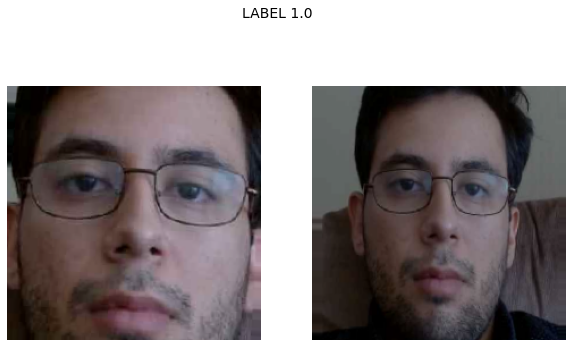

In [ ]:

selected = random.randint(0,120)
showiamges(IMAGES1,IMAGES2,LABELS,selected)

### Create Model
Usar un calsifcador mas fuerte.

In [ ]:
def initialize_base_network():
    drate = 0.1
    input = Input(shape=(224, 224,3), name="base_input")
    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    """Compute Euclidan Distance with Keras backend"""
   


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

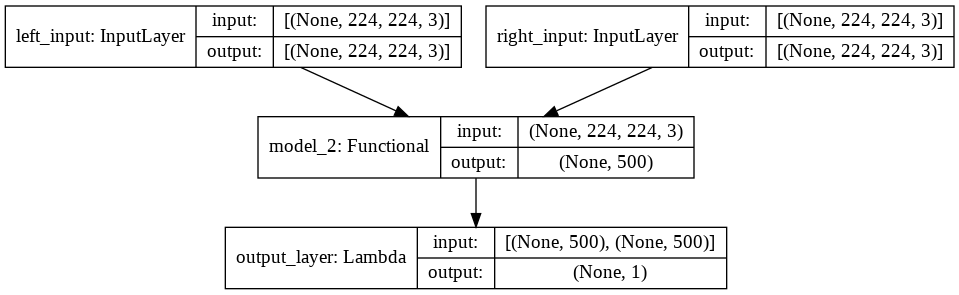

In [ ]:
base_network = initialize_base_network()
# create the left input and point to the base network


# create the right input and point to the base network


# measure the similarity of the two vector outputs

# specify the inputs and output of the model


# plot model graph


In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):



### CHECKPOINTS
path = 'saved_model_good/ownarchitecture'
checkpoint    = tf.keras.callbacks.ModelCheckpoint(filepath=path, frequency='epoch',save_weights_only=True,verbose=2)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01,patience=3,mode="min")

Epoch 1/30
72/72 [==============================] - 16s 199ms/step - loss: 23.2967 - val_loss: 48.5990
Epoch 2/30
72/72 [==============================] - 14s 193ms/step - loss: 19.0356 - val_loss: 34.0738
Epoch 3/30
72/72 [==============================] - 14s 193ms/step - loss: 14.8235 - val_loss: 19.3756
Epoch 4/30
72/72 [==============================] - 14s 192ms/step - loss: 11.8075 - val_loss: 10.8347
Epoch 5/30
72/72 [==============================] - 14s 190ms/step - loss: 9.0524 - val_loss: 7.1831
Epoch 6/30
72/72 [==============================] - 14s 194ms/step - loss: 6.6596 - val_loss: 4.9272
Epoch 7/30
72/72 [==============================] - 14s 191ms/step - loss: 5.2468 - val_loss: 4.0789
Epoch 8/30
72/72 [==============================] - 14s 195ms/step - loss: 4.5142 - val_loss: 3.6545
Epoch 9/30
72/72 [==============================] - 14s 194ms/step - loss: 3.6472 - val_loss: 2.7076
Epoch 10/30
72/72 [==============================] - 14s 191ms/step - loss: 3.2791 

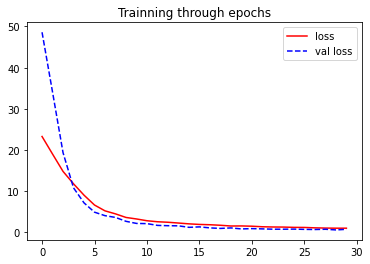

In [ ]:
loss     = history.history["loss"]
val_loss = history.history["val_loss"]
epochs   = np.arange(0,len(loss))
plt.plot(epochs,loss,"-r",label="loss")
plt.plot(epochs,val_loss,"--b",label="val loss")
plt.legend()
plt.title("Trainning through epochs")
plt.show()

### Model Evaluation

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    
    pred = y_pred.ravel() < 0.5
    
    return np.mean(pred == y_true)

In [ ]:
loss = model.evaluate(x=[IMAGES1Te, IMAGES2Te],y=LABELSTe)

y_pred_train = model.predict([IMAGES1Tr, IMAGES2Tr])
train_accuracy = compute_accuracy(LABELSTr, y_pred_train)

y_pred_test = model.predict([IMAGES1Te, IMAGES2Te])
test_accuracy = compute_accuracy(LABELSTe, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

8/8 [==============================] - 1s 65ms/step - loss: 0.7702
Loss = 0.7702136039733887, Train Accuracy = 0.7673611111111112 Test Accuracy = 0.765625


## Visualize Results

In [ ]:
### RUN THIS TO SAVE NEW INSTNACE ##
Alejandro = IMAGES2[20]
Victor    = IMAGES2[10]
Brenda    = IMAGES2[2]

BASEIMAGEs  = [Alejandro,Victor,Brenda]
NAMES       = ["Alejandro","Victor","Brenda"]

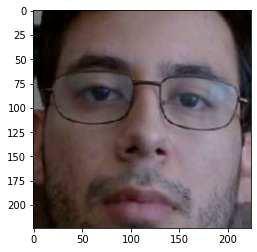

In [ ]:
plt.imshow(IMAGES2[20])

               CLASS                 ||              SELECTION


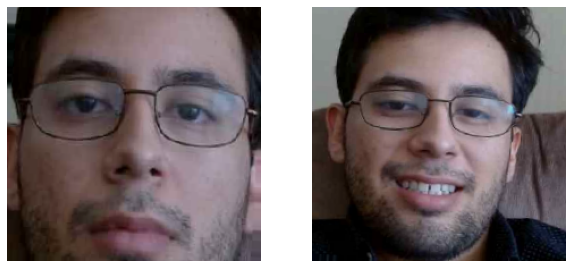

Euclidian Distance:  1.098620891571045


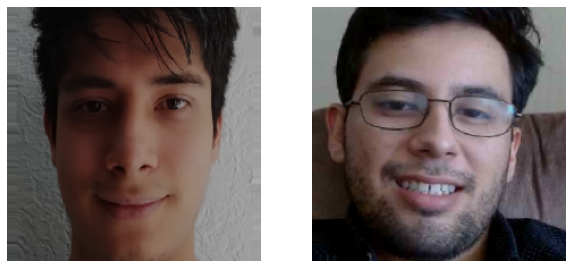

Euclidian Distance:  11.473892211914062


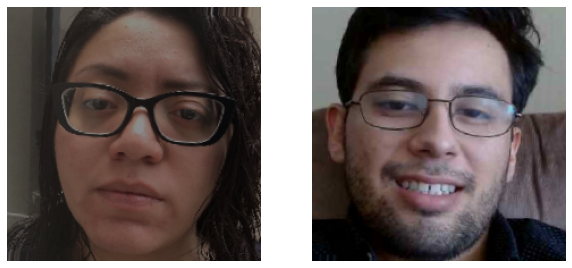

Euclidian Distance:  12.008909225463867
Person Predicted: Alejandro


In [ ]:
RANDOM = IMAGES1[20]                          # Selected Image

print("               CLASS                 ||              SELECTION")
## PLOT IMAGES ##
showiamgesPrediction(Alejandro,RANDOM,model)
showiamgesPrediction(Victor,RANDOM,model)
showiamgesPrediction(Brenda,RANDOM,model)

## SHOW PREDICTED LABELD ##
PREDICTIONS  = np.array([makeprediction(baseimage,RANDOM,model) for baseimage in BASEIMAGEs])
INDEX        = np.argmin(PREDICTIONS)
YNAME        = NAMES[INDEX]
print(f"Person Predicted: {YNAME}")